# Определение возраста покупателей

<a id="point0"></a>
# Оглавление
* [1 Загрузка и изучение данных](#Загрузка-и-изучение-данных)
* [2 Исследовательский анализ данных](#Исследовательский-анализ-данных)
* [3 Обучение модели](#Обучение-модели)
* [4 Анализ обученной модели](#Анализ-обученной-модели)
* [5 Общий вывод](#Общий-вывод)

# Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Цель исследования**: Подготовить модель для определения приблизительного возраста покупателя на основе изображения.

**Инструкция по выполнению проекта:**  
1. Проведите исследовательский анализ набора фотографий.
2. Подготовьте данные к обучению.
3. Обучите нейронную сеть и рассчитайте её качество.

## Загрузка и изучение данных
Импорт необходимых для выполнения проекта библиотек:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Установка вспомогательных настроек, функций и констант:

In [2]:
# формат вывода float-чисел датафрейма:
pd.options.display.float_format = ("{:.2f}".format)

# настройка отображения графиков:
plt.rcParams["figure.figsize"] = (15,7) # размер графиков по умолчанию:
plt.rcParams.update({'axes.grid' : True, 'grid.alpha': 0.33, 'grid.linestyle': '--'}) # отображение сетки:

def describe_info(feature):
    """
    Функция для отрисовки гистограммы и диаграммы размаха,
    а также отображения основной описательной информации признака
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        
    # Диаграмма размаха
    age_boxplot = ax1.boxplot(feature, vert=False, labels=[''])
    ax1.set_title('Диаграмма размаха значений возраста')

    # Гистограмма
    feature.hist(bins=99, ax=ax2)
    ax2.set_title('Гистограмма значений возраста')
    ax2.set_ylabel('Частота')
    ax2.axvline(18, color='r', linestyle='--', label=f"Порог совершеннолетия")
    ax2.set_xlabel('Возраст')
    ax2.legend()    
    
    # Уменьшаем расстояние между графиками
    plt.xticks(range(0, feature.max() + 1, 5))
    plt.tight_layout()
    
    # Показываем графики
    plt.show()
    
    # Описательная информация:
    whiskers = age_boxplot['whiskers']
    df = pd.concat([feature.describe(),
                    pd.DataFrame({'Нижний ус': [whiskers[0].get_xdata()[1]],
                                  'Верхний ус':[whiskers[1].get_xdata()[1]]}).T
                   ]).T
    display(df
        .style.set_caption('Описательная информация:')
        .format({col: '{:.2f}' for col in df.columns}))
    
def mae_compare(df):
    """
    Функция для отрисовки графиков МАЕ
    """    
    # Создаем график
    fig, ax = plt.subplots()
    lines = ax.plot(range(1, 6), df, marker='o')  # Линии графика
    hline1 = ax.axhline(8, color='r', linestyle='--', label="Минимальный: MAE=8")  
    hline2 = ax.axhline(7, color='#00FF00', linestyle=':', label="Оптимальный: MAE=7")
    ax.set_xticks(range(1, 6))
    
    # Первая легенда: для линий (заголовки столбцов)
    legend1 = ax.legend(lines, df.columns, loc='upper right', title="Параметры модели")
    
    # Вторая легенда: для axhline
    legend2 = ax.legend([hline1, hline2], [hline1.get_label(), hline2.get_label()], 
                        loc='upper center', title="Пороги")
    
    # Добавляем первую легенду обратно, так как второй вызов legend перезаписывает первую
    ax.add_artist(legend1)
    plt.title('Сравнение качества моделей при различных параметрах')
    plt.ylabel('Метрика MAE')
    plt.xlabel('Порядковый номер эпохи')
    plt.ylim(6,13)
    plt.show()

Загрузка данных

In [3]:
data = pd.read_csv('/datasets/faces/labels.csv')
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Отобразим общую информацию об имеющихся данных:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


**Вывод**:
Датасет 'data':
* Состоит из 7591 строк и 2 столбцов.
* Данные описывают название файла, а также реальный возраст клиентов.
* Признаки представлены двумя типами данных - 'object' и 'int64'
* Данные не содержат пропусков.
* Имеющиеся данные соответствуют описанию и структуре, заявленным заказчиком.
* Значения ячеек выглядят реалистично.
* Значения ячеек выглядят уникально.

[Вернуться к оглавлению](#point0)

## Исследовательский анализ данных
Проверим распределение целевого признака - построим диаграмму размаха и гистограмму:

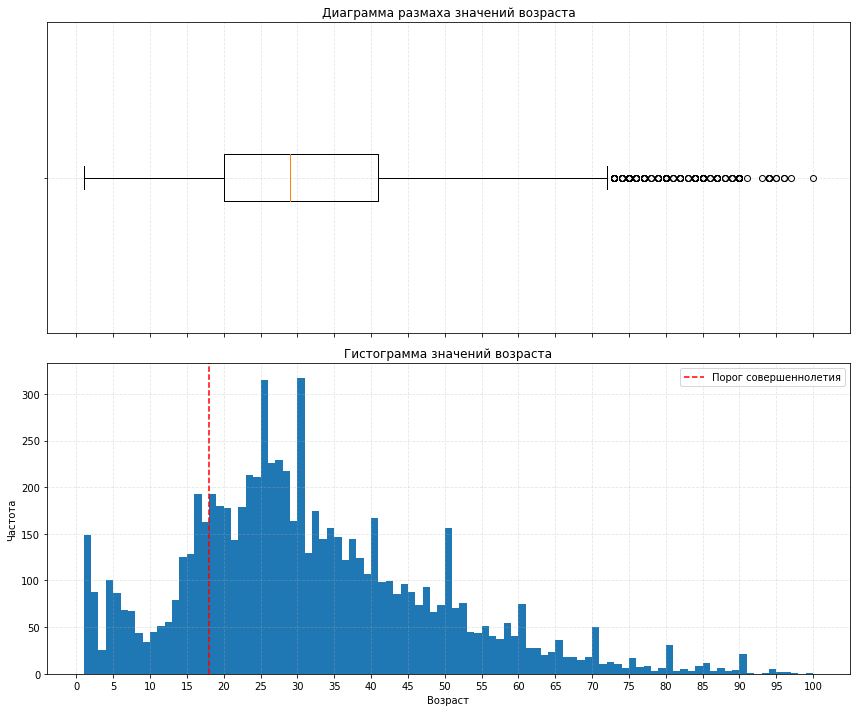

,count,mean,std,min,25%,50%,75%,max,Нижний ус,Верхний ус
0,7591.00,31.20,17.15,1.00,20.00,29.00,41.00,100.00,1.00,72.00


In [5]:
describe_info(data['real_age'])

* Наблюдаем бимодальное распределение целевого признака с первым пиком в районе 27 лет и вторым - около 4 лет.
* Наблюдается неравномерность распределения данных:
  * для пиковых значений в районе 27 лет частота достигает более 200, для отдельных возрастов более 300. 
  * для пиковых значений в районе 4 лет - около 100-150.
  * наблюдаются категории с явно меньшими частотами - например, около значения 10 и значения более 55 - частота меньше 50.
* Неравномерность распределения данных может ухудшить качество предсказания модели для категорий возрастов с низкими частотами.
* Одна из целей применения модели - определения возраста для продажи алкоголя совершеннолетним клиентам
  * в данном случае, в районе 18 лет мы наблюдаем достаточные частоты признаков, следовательно качество предсказания, основывающееся только на доступных в датасете примерах, не должно пострадать.
* Если неравномерность распределения будет критично влиять на качество предсказания - необходимо будет предусмотреть вариант предобработки данных, устраняющий низкие частоты для определенных категорий возрастов - например аугментацию или оверсэмплинг.

Проверим контент изображений

Found 7591 validated image filenames.


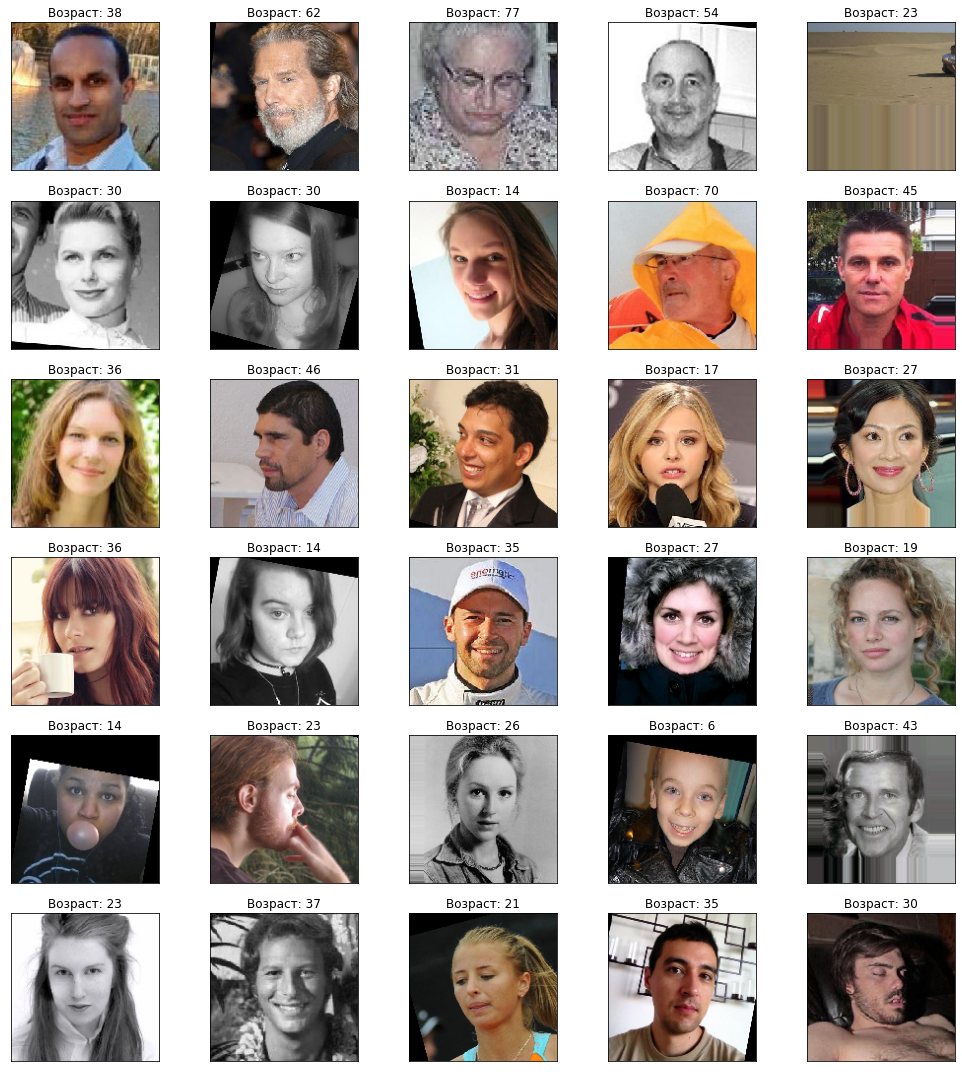

In [6]:
# Создаем объект ImageDataGenerator:
datagen = ImageDataGenerator(rescale=1./255)

# Настраиваем генератор данных:
datagen_flow = datagen.flow_from_dataframe(
    dataframe=data,                           # загрузка датафрейма
    directory='/datasets/faces/final_files/', # путь к папке с изображениями
    x_col='file_name',                        # колонка с именами файлов
    y_col='real_age',                         # колонка с метками (возрастом)
    target_size=(150, 150),                   # размер, до которого будут изменены изображения
    batch_size=32,                            # размер батча
    class_mode='raw',                         # для регрессии используем 'raw' (численные значения)
    shuffle=True                              # перемешивание данных
)

# Получение пары «картинки — метки»:
features, target = next(datagen_flow)

# Вывод изображений:
fig = plt.figure(figsize=(15,15))

for i in range(30):
    fig.add_subplot(6, 5, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Выводы**:
* Наблюдаем бимодальное распределение целевого признака с первым пиком в районе 27 лет и вторым - около 4 лет.
* Наблюдается разница в частоте целевого признака для различных категорий возраста.
* Представлены цветные изображения и изображения в градации серого цвета.
* Для некоторых изображений заметен наклон.
* Контент изображений выглядит уникально.

[Вернуться к оглавлению](#point0)

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

SEED = 42

def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255)
    
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',        
        subset='training', # указываем, что это загрузчик для обучающей выборки
        seed=SEED)
            
    return train_datagen_flow

def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255)
    
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',        
        subset='validation', # указываем, что это загрузчик для валидационной выборки
        seed=SEED)
            
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                     # weights='imagenet'
                     weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                     include_top=False)
                     
    model = Sequential()    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(learning_rate=0.00005)
    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=3,
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)

    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/3
356/356 - 69s - loss: 255.4790 - mae: 11.3545 - val_loss: 1009.6042 - val_mae: 27.0875
Epoch 2/3
356/356 - 47s - loss: 71.8202 - mae: 6.3859 - val_loss: 280.5351 - val_mae: 12.9125
Epoch 3/3
356/356 - 47s - loss: 37.4969 - mae: 4.7269 - val_loss: 77.8328 - val_mae: 6.7363

119/119 - 11s - loss: 77.8328 - mae: 6.7363

```

[Вернуться к оглавлению](#point0)

## Анализ обученной модели

Для решения задачи регрессии - **определение возраста покупателей на основе изображения** - я использовал нейронную сеть на основе архитектуры ResNet.

Прототип модели я взял из задачи теоретического курса (см.: [ResNet в Keras](https://practicum.yandex.ru/learn/data-scientist/courses/93ff2ac1-e90e-46d0-81d2-f7abf829a8b6/sprints/317106/topics/a5816b72-4a74-430e-9c5b-053b4add8ffc/lessons/af2bfceb-ba70-48ec-8d6a-f0fd97e5e12b/)). Я выбрал эту модель, поскольку она показала хорошую метрику качества при решении поставленной ранее задачи.

Мой итоговый код модели ResNet50 для регрессии выглядит так:<br>
<code>def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                     weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                     # weights='imagenet',
                     include_top=False)                     
    model = Sequential()    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))    
    optimizer = Adam(learning_rate=0.00005)
    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=['mae'])
    return model
</code>

Где:
* **backbone**:
  * `backbone = ResNet50()` - формирование "костяка" модели ResNet50
  * `weights='imagenet'` - инициализация весов. Я использую предобученную на датасете ImageNet модель; в качестве аргумента - ссылка на локальный файл весов.
  * `include_top=False` - указание на то, что в конце архитектуры ResNet не будет слоев GlobalAveragePooling2D и Dense.
* **model**:
  * `model = Sequential()` - инициализация нейронной сети класса Sequential (последовательная)
  * `model.add(backbone)` - добавление "костяка"
  * `model.add(GlobalAveragePooling2D())` - добавление пулинга с окном во весь тензор. Возвращает среднее значение из группы пикселей внутри канала. GlobalAveragePooling2D нужен, чтобы усреднить информацию по всему изображению, то есть получить пиксель с большим количеством каналов (например, 512 для ResNet50).
  * `model.add(Dense(1, activation='relu'))` - добавление полносвязного слоя:
    * количество нейронов в слое: 1
    * функция активации: ReLU  
* **compile**:
  * `loss='mean_squared_error'` - в качестве функции потерь используется MSE. Попробовал использовать MSE, а не MAE (которая задана в качестве метрики качества), чтобы <abbr title="'зачастую нейронные сети с функцией потерь MSE обучаются быстрее'">ускорить процесс обучения</abbr>.
  * `optimizer=optimizer` - указание алгоритма обучения:
    * `optimizer = Adam(learning_rate=0.00005)` - алгоритм обучения нейронной сети Adam со скоростью обучения 0.00005
  * `metrics=['mae']` - метрика качества модели: MAE, это **задано условием**.  

Подбор параметров модели проходил в несколько итераций:
1. Я начал обучение модели со стандартной скоростью: `learning_rate=0.001` и 3 эпох обучения. С такими параметрами удалось достичь метрики `val_mae: 17.41` на третьей эпохе, с минимумом `val_mae: 12.46` на второй.
2. Далее я уменьшил скорость обучения - установил `learning_rate=0.0001` и 3 эпохи обучения. С такими параметрами модель показала метрику качества MAE=7.11, что меньше минимального порога MAE=8.   

✅ Это удовлетворительный результат, но я попробовал сделать еще несколько попыток, чтобы достичь <abbr title="если вы получите MAE меньше 7, это будет отличный результат!">"отличного результата"</abbr>.

3. При прежней скорости обучения `learning_rate=0.0001` я увеличил количество эпох. В целом метрика улучшилась - MAE=6.6897 на 5 эпохе, но меня смутило, что минимум был достигнут на 3 эпохе (MAE=6.34), и далее модель переобучалась, снижая качество.
4. Попробовал выбрать "золотую середину" - `learning_rate=0.0001` и 4 эпохи. Итоговый MAE=7.51, при том, что на последней эпохе модель опять ухудшила свое качество.
5. Еще немного уменьшил скорость обучения `learning_rate=0.00005` и 3 эпохи. С такими параметрами модель показала метрику MAE=6.7363, при том, видно, что каждая эпоха улучшает результат и не проявляется переобучения. ✅

На этом я решил остановиться, поскольку по условию это считается "отличным результатом".
Если бы стояла задача и далее повышать качество модели, то я бы попытался использовать следующие методы:
* Подбор **скорости обучения**. В моем случае я остановился на learning_rate=0.00005, но возможно, дальнейшее уменьшение также сможет даст прирост качества.
* Подбор **количества эпох**. Для установленных параметров модели у меня получилось оптимальное число эпох равное 3. 4 или 5 эпох - показывают переобучение, но возможно, что при других параметрах оптимальное число эпох также изменится.
* **Усложнение нейросети**. Для моего случая, с целью экономии времени, я взял модель из задачи, которая была рассмотрена в теории курса. Можно попробовать усложнить нейросеть, возможно это даст ощутимый прирост качества.
* Использование **MAE в качестве функции потерь**. В текущем варианте, с целью повышения скорости обучения, в качестве функции потерь используется MSE. Возможно, использование MAE позволит улучшить качество модели.
* **Предобработка данных**. Для улучшения качества обучения можно применить аугментацию изображений. Поскольку в имеющемся датасете присутствует дисбаланс по целевому признаку, можно попробовать применить оверсэмплинг, чтобы улучшить качество прогноза по всем возрастным категориям.


Представлю полученные результаты в виде таблицы и виде графика:

,1,2,3,4,5
"lr=0.001, epochs=3",26.49,12.46,17.41,NaN,NaN
"lr=0.0001, epochs=3",14.51,11.03,7.11,NaN,NaN
"lr=0.0001, epochs=5",21.97,8.20,6.34,6.56,6.69
"lr=0.0001, epochs=4",19.75,10.97,7.17,7.51,NaN
"lr=0.00005, epochs=3",27.09,12.91,6.74,NaN,NaN


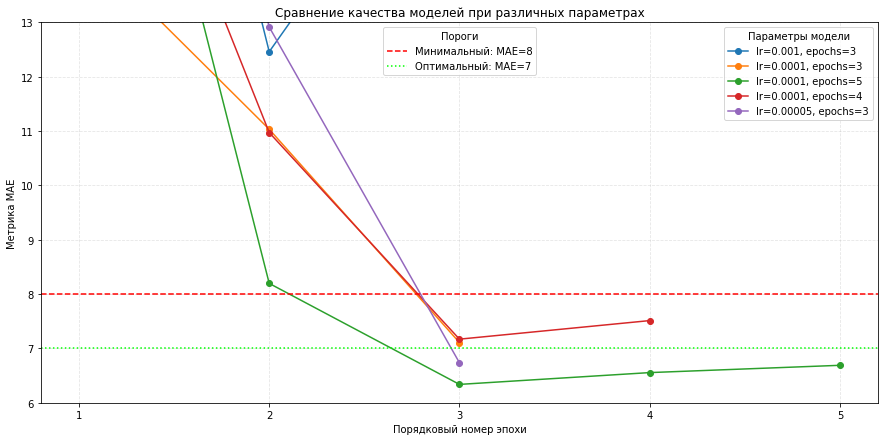

In [7]:
val_mae = pd.DataFrame({
    'lr=0.001, epochs=3'  :[26.4908, 12.4586, 17.4080, float('nan'), float('nan')],
    'lr=0.0001, epochs=3' :[14.5093, 11.0317,  7.1089, float('nan'), float('nan')],
    'lr=0.0001, epochs=5' :[21.9724,  8.1963,  6.3385,       6.5556,       6.6897],
    'lr=0.0001, epochs=4' :[19.7497, 10.9710,  7.1707,       7.5122, float('nan')],
    'lr=0.00005, epochs=3':[27.0875, 12.9125,  6.7363, float('nan'), float('nan')],
    }, index=range(1,6))
display(val_mae.T)

mae_compare(val_mae)

**Вывод**:
* На основе имеющихся данных подобрана модель нейронной сети на основе архитектуры ResNet.
* Метрика качества модели MAE=6.7363 при скорости обучения 0.00005 и количестве эпох равном 3. 
* Качество полученной модели удовлетворяет заданному условию: MAE ≤ 8.

[Вернуться к оглавлению](#point0)

## Общий вывод
Для данных в виде набора фотографий людей с указанием возраста предоставленных сетевым супермаркетом «Хлеб-Соль» с поставленной целью - подготовки модели для определения приблизительного возраста покупателя на основе изображения - было проведено исследование, в рамках которого:

1. Произведено предварительное изучение данных:
Проверена корректность и соответствие предоставленных данных заявленным заказчиком
2. Проведен исследовательский анализ данных:
* Изучен характер распределения целевого признака.
* Проверен контент представленных изображений.
3. Произведено обучение модели нейронной сети для решения задачи регрессии
4. Проведен анализ обученной модели:
* Для решения задачи использована нейронная сеть со следующими параметрами:
  * модель на основе архитектуры ResNet, предобученная на датасете ImageNet;
  * в качестве функции потери используется MSE, с целью ускорить процесс обучения;
  * В качестве алгоритма обучения нейронной сети - Adam со скоростью обучения 0.00005
  * В качестве метрики качества модели: Mean Absolute Error (MAE).
  * Количество эпох обучения: 3
* При заданных параметрах удалось достичь метрики качества MAE=6.7363, что удовлетворяет заданному условию.
* В процессе подбора оптимальных параметров также определены потенциальные пути дальнейшего улучшения качества модели.

Таким образом, для решения поставленной задачи удалось подобрать такую конфигурацию модели нейронной сети ResNet50, при которой был достигнут заданный уровень качества предсказания приблизительного возраста покупателя на основе изображения.

[Вернуться к оглавлению](#point0)